# Install and Import library

In [49]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [50]:
import pandas as pd
import yfinance as yf

# Import price data



In [51]:
start = '2021-01-01'
end = '2023-01-15'

In [52]:
data = yf.download('URTH', start=start, end=end)

[*********************100%***********************]  1 of 1 completed


# copy data

In [53]:
df = data.copy()

# MACD Function

In [54]:
def macd_func(df,a=12,b=21,c=9):
  EMA_short = df['Close'].ewm(span=a, adjust=False,min_periods= a+1).mean()
  EMA_long = df['Close'].ewm(span=b, adjust=False,min_periods= b+1).mean()
  MACD = EMA_short - EMA_long
  signal = MACD.ewm(span=c, adjust=False,min_periods=c+1).mean()
  df['macd'] = MACD
  df['signal_line'] = signal
  df['histogram'] = df['macd'] - df['signal_line']
  
  #find entry point
  df['shift_hist'] = df['histogram'].shift(1)
  df[(df['histogram'] > 0) & (df['shift_hist'] < 0)]
  df.loc[(df['histogram']> 0) &  (df['shift_hist'] < 0 ), 'action'] = 'buy'
  df.loc[(df['histogram']< 0) &  (df['shift_hist'] > 0 ), 'action'] = 'sell'
  df.loc[df['action'] == 'buy', 'marker_position'] = df['Low'] *0.98
  df.loc[df['action'] == 'sell', 'marker_position'] = df['High'] *1.02


  return df

# Strategy Return Function

In [55]:
def strategy_return(df, action_price = 'Open', long_or_short='long'):
  
  action_df = df.loc[df['action'].notnull()]

  if action_price == 'Open':
    action_df['action_price'] = df['Open'].shift(-1)
    action_df['return'] = action_df['action_price'].pct_change()


  elif action_price == 'Close':
    action_df['action_price'] = df['Close']
    action_df['return'] = action_df['action_price'].pct_change()

  elif action_price == 'Adj Close':
    action_df['action_price'] = df['Adj Close']
    action_df['return'] = action_df['Adj Close'].pct_change()

  else:
    raise ValueError('Not correct action price, choose between {Open, Close, Adj Close}')

  
  record_df = action_df[['action','action_price','return']]
  record_df.reset_index(inplace=True)
  record_df['previous_signal_date'] = record_df['Date'].shift(1)
  record_df['previous_action'] = record_df['action'].shift(1)
  record_df['previous_action_price'] = record_df['action_price'].shift(1)
  record_df.rename(columns={'Date':'signal_date'}, inplace=True)


  if long_or_short == 'long':
    summary_df = record_df[record_df.action == 'sell']
    print('long strategy')
  
  elif long_or_short == 'short':
    summary_df = record_df[record_df.action == 'buy']
    summary_df['return'] = summary_df['return'] * -1
    print('short strategy')

  else:
    raise ValueError('Not correct long_or_short, choose between {long, short}')

  return action_df, record_df, summary_df

# Starter

In [56]:
starter = macd_func(df)

In [57]:
starter

,Open,High,Low,Close,Adj Close,Volume,macd,signal_line,histogram,shift_hist,action,marker_position
Date,,,,,,,,,,,,
2021-01-04 00:00:00-05:00,113.529999,113.769997,110.620003,111.629997,108.164688,187100,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-05 00:00:00-05:00,111.510002,112.709999,111.510002,112.489998,108.997986,120300,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-06 00:00:00-05:00,112.120003,114.180000,112.120003,113.169998,109.656891,83600,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-07 00:00:00-05:00,113.860001,114.709999,113.860001,114.470001,110.916534,28600,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-08 00:00:00-05:00,115.150002,115.309998,114.059998,115.309998,111.730453,84400,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-09 00:00:00-05:00,112.250000,113.000000,111.500000,111.580002,111.580002,459800,-0.184239,-0.341799,0.157560,0.063426,NaN,NaN
2023-01-10 00:00:00-05:00,111.339996,112.190002,111.099998,112.190002,112.190002,111000,-0.040559,-0.281551,0.240992,0.157560,NaN,NaN
2023-01-11 00:00:00-05:00,112.669998,113.419998,112.489998,113.410004,113.410004,181600,0.147314,-0.195778,0.343092,0.240992,NaN,NaN


In [58]:
a,b,c = strategy_return(starter,'Open','long')

long strategy


<ipython-input-55-df6f780dd235>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  action_df['action_price'] = df['Open'].shift(-1)
<ipython-input-55-df6f780dd235>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  action_df['return'] = action_df['action_price'].pct_change()
<ipython-input-55-df6f780dd235>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

In [59]:
c

,signal_date,action,action_price,return,previous_signal_date,previous_action,previous_action_price
0,2021-02-23 00:00:00-05:00,sell,116.599998,NaN,NaT,NaN,NaN
2,2021-03-24 00:00:00-04:00,sell,116.070000,-0.012926,2021-03-11 00:00:00-05:00,buy,117.589996
4,2021-04-22 00:00:00-04:00,sell,123.260002,0.045640,2021-03-29 00:00:00-04:00,buy,117.879997
6,2021-06-15 00:00:00-04:00,sell,126.570000,0.007081,2021-05-24 00:00:00-04:00,buy,125.680000
8,2021-07-16 00:00:00-04:00,sell,125.250000,-0.009490,2021-06-29 00:00:00-04:00,buy,126.449997
10,2021-08-18 00:00:00-04:00,sell,128.070007,-0.007671,2021-07-23 00:00:00-04:00,buy,129.059998
12,2021-09-09 00:00:00-04:00,sell,132.649994,0.004544,2021-08-27 00:00:00-04:00,buy,132.050003
14,2021-11-11 00:00:00-05:00,sell,135.509995,0.060163,2021-10-12 00:00:00-04:00,buy,127.820000
16,2021-12-14 00:00:00-05:00,sell,131.800003,-0.020875,2021-12-09 00:00:00-05:00,buy,134.610001
18,2022-01-06 00:00:00-05:00,sell,133.250000,-0.011499,2021-12-23 00:00:00-05:00,buy,134.800003


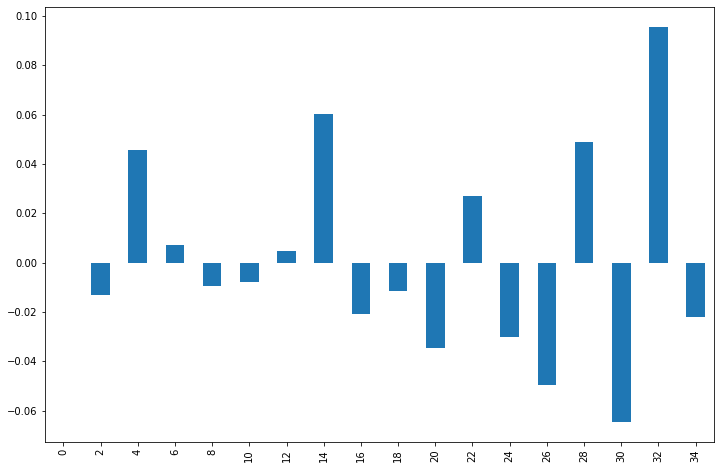

In [60]:
c['return'].plot(kind='bar',figsize=(12,8))

In [61]:
c.mean()

<ipython-input-61-d9364bfe674f>:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  c.mean()
<ipython-input-61-d9364bfe674f>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  c.mean()


action_price             121.073889
return                     0.001451
previous_action_price    121.212941
dtype: float64